In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch import Tensor
import torch.optim as optim


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io
from prettytable import PrettyTable

torch.set_default_dtype(torch.float)

# Random number generators in other libraries
np.random.seed(28)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 

cpu


In [2]:
# Lucas/this_script.py
import sys
import os
current_dir = os.getcwd()
print(current_dir)
# Add the 'functions' folder to the Python path
functions_dir = os.path.join(current_dir,'..', 'functions')
sys.path.append(functions_dir)
functions_dir = os.path.join(current_dir,'..', 'Mads')
sys.path.append(functions_dir)

# Now you can import the function
from Load_data import custom_csv_parser2, custom_csv_parser
from Load_data import data_split

pde_keys = ['D1', 'D2', 'I_sc','I_p', 'I_eff', 'G', 'G_sc']
patient_keys = ['tau1', 'tau2', 'Ci', 'p2', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']
patient_keys_si = ['tau1', 'tau2', 'Ci', 'p2', 'Si', 'GEZI', 'EGP0', 'Vg', 'taum', 'tausc']

def dict_to_vec(X, t):
    
    t  = int(t)
    print(t)
    X_vec = torch.tensor([X['D1'][t], X['D2'][t], X['I_sc'][t], X['I_p'][t], X['I_eff'][t], X['G'][t], X['G_sc'][t]], device=device, dtype=torch.float32)

    return X_vec.to(device).reshape(1, -1)

scale_vec = torch.tensor([1.56, 1.54, 1.24, 1.24, 0.01, 117.56, 117.48], device=device, dtype=torch.float32)
# Use the function
data = custom_csv_parser2('../Patient2.csv')
parms = custom_csv_parser('../Patient.csv')


Si_true = parms['Si']
tau1_true = parms['tau1']
tau2_true = parms['tau2']
Ci_true = parms['Ci']
p2_true = parms['p2']
GEZI_true = parms['GEZI'][0]
EGP0_true = parms['EGP0']
Vg_true = parms['Vg']
taum_true = parms['taum']
tausc_true = parms['tausc']

print("True parms", Si_true, tau1_true, tau2_true, Ci_true, p2_true, GEZI_true, EGP0_true, Vg_true, taum_true, tausc_true)

X_train, X_test, ts_train, ts_test, ts, X_train_arr, X_test_arr = data_split(data)
G_true = X_train["G"]
ts_train = torch.tensor(ts_train, device=device, dtype=torch.float32).unsqueeze(1)
ts_test = torch.tensor(ts_test, device=device, dtype=torch.float32).unsqueeze(1)
#print(ts_train.shape)
X_train_arr = torch.tensor(X_train_arr, device=device, dtype=torch.float32)
X_test_arr = torch.tensor(X_test_arr, device=device, dtype=torch.float32)

print(X_train_arr.shape)
print(X_test_arr.shape)

c:\DeepLearning-PINNs\Lucas
Training data loaded successfully!
True parms 0.0081 49.0 47.0 20.1 0.0106 0.0022 1.33 253.0 47.0 5.0
torch.Size([450, 7])
torch.Size([2550, 7])


# Hyperparamters

In [3]:
p = 0.0

In [4]:
class DNN(nn.Module):
    '''Network'''
    def __init__(self, layers):
        super(DNN, self).__init__()

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1] ) for i in range(len(layers)-1)])

        self.activation = nn.Tanh()

        self.dropout = nn.Dropout(p=p)

        'Initialization'
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linears[i].weight, gain=1.0)
            nn.init.zeros_(self.linears[i].bias)

    def forward(self, x):
        for i in range(0, len(self.linears) - 1):
            x = self.linears[i](x)
            x = self.activation(x)
            x = self.dropout(x)
        x = self.linears[-1](x)
        return x

In [5]:
def pdes(u, nn_dt, ts):
    pdes = torch.zeros_like(u, device=device)
    D1 = u[:, 0]  
    D2 = u[:, 1]  
    I_sc = u[:, 2]  
    I_p = u[:, 3]  
    I_eff = u[:, 4]  
    G = u[:, 5]  
    G_sc = u[:, 6]  
    
    # Convert parameters to tensors
    #taum = torch.tensor(parms['taum'], device=device)
    #tau1 = torch.tensor(parms['tau1'], device=device)
    # tau2 = torch.tensor(parms['tau2'], device=device)
    # p2 = torch.tensor(parms['p2'], device=device)
    # Ci = torch.tensor(parms['Ci'], device=device)
    # GEZI = torch.tensor(parms['GEZI'], device=device)
    # EGP0 = torch.tensor(parms['EGP0'], device=device)
    # Vg = torch.tensor(parms['Vg'], device=device)
    # tausc = torch.tensor(parms['tausc'], device=device)

    ds = torch.zeros_like(u[:,0], device=device)
    us = torch.ones_like(u[:,0], device=device) * 25.04
    zero_indices = (ts == 0).nonzero(as_tuple=True)[0]
    us[zero_indices] = data['Insulin'][0]
    ds[zero_indices] = data['Meal'][0]
    
    # Example assignment for all rows of pdes
    pdes[:, 0] = nn_dt[:, 0] + D1 / taum - ds
    pdes[:, 1] = nn_dt[:, 1] - (D1 - D2) / taum
    pdes[:, 2] = nn_dt[:, 2] + I_sc / tau1 - us / (tau1 * Ci)
    pdes[:, 3] = nn_dt[:, 3] - (I_sc - I_p) / tau2
    pdes[:, 4] = nn_dt[:, 4] + p2 * I_eff - p2 * Si * I_p
    pdes[:, 5] = nn_dt[:, 5] + (GEZI + I_eff) * G - EGP0 - 1000 * D2 / (Vg * taum)
    pdes[:, 6] = nn_dt[:, 6] - (G - G_sc) / tausc

    return pdes / scale_vec

class PINN():
    def __init__(self, layers):
        self.iter = 0
        self.nn = DNN(layers).to(device)

    def data_loss(self, ts, data):
        u = self.nn(ts)  # Outputs ts x 7 array
        loss = u - data
        return torch.sum(loss**2)


    def pde_loss(self, ts):
        
        ts = ts.clone().detach()
        ts = ts.requires_grad_(True)
        u = self.nn(ts)        
        nn_dt = torch.zeros_like(u, device=device)

        for i in range(u.shape[1]):
            nn_dt[:, i] = autograd.grad(u[:, i], ts, grad_outputs=torch.ones_like(u[:, i]), create_graph=True)[0].squeeze()

        pd = pdes(u, nn_dt, ts)
        loss = nn.MSELoss()(pd, torch.zeros_like(pd))
        return loss
    
    def loss(self, ts, data):
        l1 = self.data_loss(ts, data)
        l2 = self.pde_loss(ts)
        return l1 + 100*l2, l1, 100*l2
    
    def test(self, t):
        #t = t.unsqueeze(0)
        X_pred = self.nn.forward(t)
        #X_true = dict_to_vec(data, t)
        if len(t) == 450:
            X_true = X_train_arr
        else:
            X_true = X_test_arr
        error_vec = torch.linalg.norm((X_true-X_pred),2)/torch.linalg.norm(X_true,2)
        X_pred = X_pred.cpu().detach().numpy()
        return X_pred, error_vec


In [6]:
NN = PINN([1, 64, 128, 128, 7])
Si0 = 0.001
tau10 = 45.0
tau20 = 45.0
Ci0 = 17.0
p20 = 0.0005
GEZI0 = 0.0005
EGP00 = 2.0
Vg0 = 300.0
taum0 = 50.0
tausc0 = 6.0

p = 0.0
lr = 5e-4
Si = torch.tensor([Si0], requires_grad=True, device=device)
tau1 = torch.tensor([tau10], requires_grad=True, device=device)
tau2 = torch.tensor([tau20], requires_grad=True, device=device)
Ci = torch.tensor([Ci0], requires_grad=True, device=device)
p2 = torch.tensor([p20], requires_grad=True, device=device)
GEZI = torch.tensor([GEZI0], requires_grad=True, device=device)
EGP0 = torch.tensor([EGP00], requires_grad=True, device=device)
Vg = torch.tensor([Vg0], requires_grad=True, device=device)
taum = torch.tensor([taum0], requires_grad=True, device=device)
tausc = torch.tensor([tausc0], requires_grad=True, device=device)

optimizer = optim.Adam(list(NN.nn.parameters()) + [Si, tau1, tau2, Ci, p2, GEZI, EGP0, Vg, taum, tausc], lr=lr)

'''Test Network works'''
pred, err = NN.test(torch.tensor([1], device=device, dtype=torch.float32))
print(f"""Prediction: {pred} \n Error: {err}""")
print(f"Current guess for {Si.item()}: ")

pred = NN.nn.forward(ts_train)
true = X_train_arr
#plt.plot(ts_train.cpu().detach().numpy(), pred.cpu().detach().numpy()[:,5], label='Prediction')
#print(torch.mean((pred - true)**2))

Prediction: [ 0.1721797   0.07470991  0.05156173  0.16550967  0.14954449 -0.01177089
 -0.20731138] 
 Error: 1.0009090900421143
Current guess for 0.0010000000474974513: 


In [7]:
start_time = time.time()
ts_train = torch.tensor(ts_train, device=device, dtype=torch.float32).reshape(-1,1)
ts_test = torch.tensor(ts_test, device=device, dtype=torch.float32).reshape(-1,1)
epochs = 30000
NN.nn.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss, l1, l2 = NN.loss(ts_train, X_train_arr)
    loss.backward()
    optimizer.step()
    if epoch % 2000 == 0:
        print(f"Epoch: {epoch}, Data loss: {l1.item():.4f}, ODE loss: {l2.item():.4f}, Si: {Si.item():.5f}, tau1: {tau1.item():.5f}")
        if epoch % 2000 == 0:
            with torch.no_grad():
                NN.nn.eval()
                pred, err = NN.test(ts_test)
                print(f"Test Error: {err:.2f}")
            NN.nn.train()







C:\Users\lucas\AppData\Local\Temp\ipykernel_6792\3268563066.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_train = torch.tensor(ts_train, device=device, dtype=torch.float32).reshape(-1,1)
C:\Users\lucas\AppData\Local\Temp\ipykernel_6792\3268563066.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ts_test = torch.tensor(ts_test, device=device, dtype=torch.float32).reshape(-1,1)


Epoch: 0, Data loss: 12533568.0000, ODE loss: 137.1635, Si: 0.00150, tau1: 45.00050
Test Error: 1.00
Epoch: 2000, Data loss: 286245.8125, ODE loss: 130.3594, Si: 0.05559, tau1: 45.39083
Test Error: 0.15
Epoch: 4000, Data loss: 19955.5664, ODE loss: 130.3564, Si: 0.05711, tau1: 46.14439
Test Error: 0.04
Epoch: 6000, Data loss: 19771.2793, ODE loss: 130.9904, Si: 0.06413, tau1: 45.69871
Test Error: 0.04
Epoch: 8000, Data loss: 8447.1367, ODE loss: 30.6383, Si: 0.12683, tau1: 44.92079
Test Error: 0.03
Epoch: 10000, Data loss: 8362.0439, ODE loss: 0.1351, Si: 0.04865, tau1: 43.96490
Test Error: 0.03
Epoch: 12000, Data loss: 8324.4785, ODE loss: 0.1498, Si: 0.01079, tau1: 44.68089
Test Error: 0.03
Epoch: 14000, Data loss: 17.5163, ODE loss: 0.1969, Si: 0.02752, tau1: 45.13241
Test Error: 0.00
Epoch: 16000, Data loss: 13.9760, ODE loss: 0.1663, Si: 0.00378, tau1: 45.19344
Test Error: 0.00
Epoch: 18000, Data loss: 21.3617, ODE loss: 0.1455, Si: 0.00371, tau1: 44.97289
Test Error: 0.00
Epoch: 

In [9]:
table = PrettyTable()

table.field_names = ["Parameter", "True Value", "Final Guess", "Relative Error"]

# Calculate relative error and add rows with formatted values
table.add_row(["Si", f"{Si_true:.4f}", f"{Si.item():.4f}", f"{abs(Si_true - Si.item()) / Si_true:.4f}"])
table.add_row(["tau1", f"{tau1_true:.4f}", f"{tau1.item():.4f}", f"{abs(tau1_true - tau1.item()) / tau1_true:.4f}"])
table.add_row(["tau2", f"{tau2_true:.4f}", f"{tau2.item():.4f}", f"{abs(tau2_true - tau2.item()) / tau2_true:.4f}"])
table.add_row(["Ci", f"{Ci_true:.4f}", f"{Ci.item():.4f}", f"{abs(Ci_true - Ci.item()) / Ci_true:.4f}"])
table.add_row(["p2", f"{p2_true:.4f}", f"{p2.item():.4f}", f"{abs(p2_true - p2.item()) / p2_true:.4f}"])
table.add_row(["GEZI", f"{GEZI_true:.4f}", f"{GEZI.item():.4f}", f"{abs(GEZI_true - GEZI.item()) / GEZI_true:.4f}"])
table.add_row(["EGP0", f"{EGP0_true:.4f}", f"{EGP0.item():.4f}", f"{abs(EGP0_true - EGP0.item()) / EGP0_true:.4f}"])
table.add_row(["Vg", f"{Vg_true:.4f}", f"{Vg.item():.4f}", f"{abs(Vg_true - Vg.item()) / Vg_true:.4f}"])
table.add_row(["taum", f"{taum_true:.4f}", f"{taum.item():.4f}", f"{abs(taum_true - taum.item()) / taum_true:.4f}"])
table.add_row(["tausc", f"{tausc_true:.4f}", f"{tausc.item():.4f}", f"{abs(tausc_true - tausc.item()) / tausc_true:.4f}"])

print(table)

+-----------+------------+-------------+----------------+
| Parameter | True Value | Final Guess | Relative Error |
+-----------+------------+-------------+----------------+
|     Si    |   0.0081   |   -0.0030   |     1.3756     |
|    tau1   |  49.0000   |   44.9154   |     0.0834     |
|    tau2   |  47.0000   |   47.0476   |     0.0010     |
|     Ci    |  20.1000   |   19.9086   |     0.0095     |
|     p2    |   0.0106   |    0.0001   |     0.9871     |
|    GEZI   |   0.0022   |    0.0011   |     0.5020     |
|    EGP0   |   1.3300   |    1.0274   |     0.2275     |
|     Vg    |  253.0000  |   294.6031  |     0.1644     |
|    taum   |  47.0000   |   55.1169   |     0.1727     |
|   tausc   |   5.0000   |   11.1696   |     1.2339     |
+-----------+------------+-------------+----------------+


C:\Users\lucas\AppData\Local\Temp\ipykernel_6792\3104593107.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print("Error" , torch.sum((torch.tensor(pred[:,i]) - X_test_arr[:,i])**2))


Error tensor(10.5476)


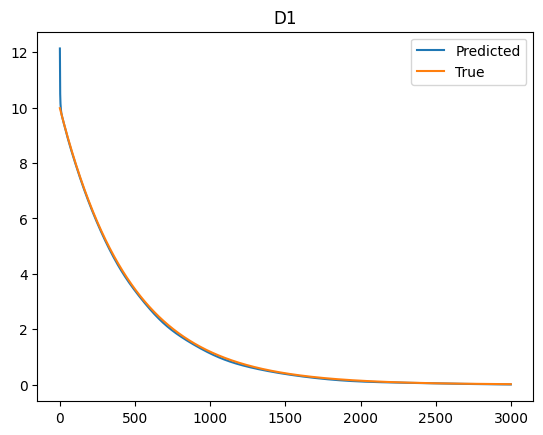

Error tensor(7.0178)


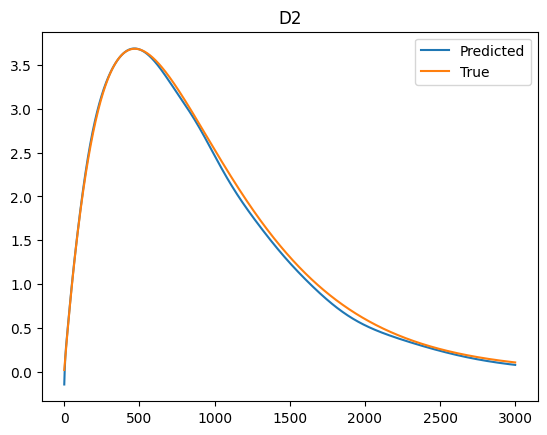

Error tensor(0.0140)


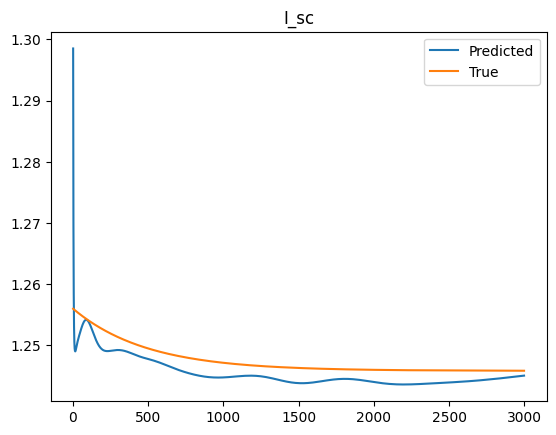

Error tensor(0.0313)


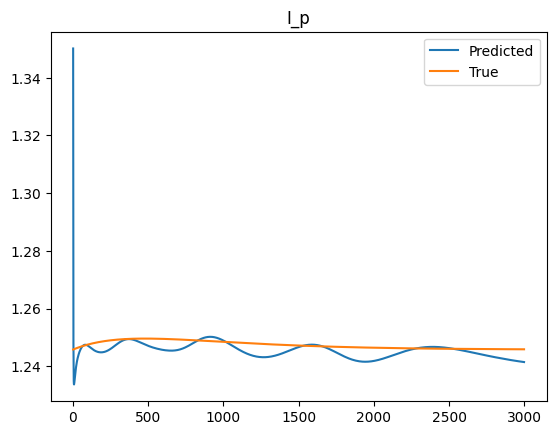

Error tensor(0.0431)


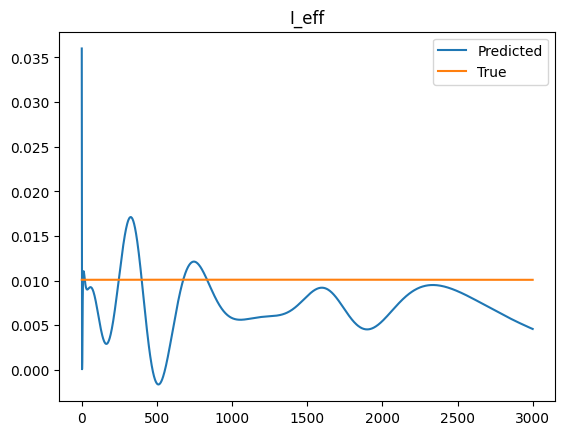

Error tensor(223.5571)


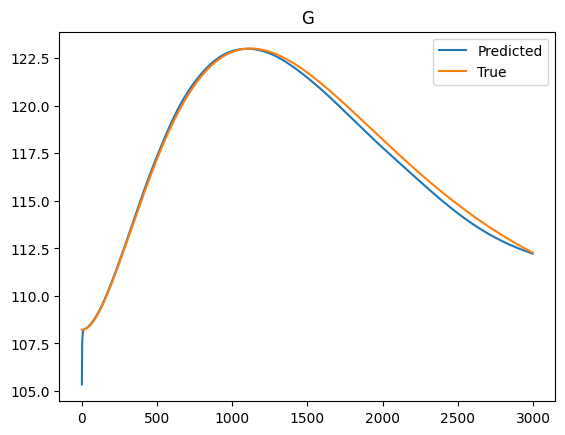

Error tensor(228.5317)


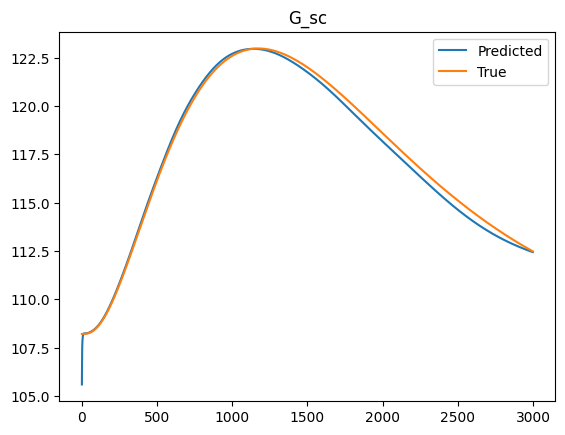

In [10]:
NN.nn.eval()
pred = NN.nn.forward(ts_test)


G_pred = pred[:,5].reshape(-1,1)
G_true = X_test_arr[:,5].reshape(-1,1)
G_true_2 = X_train_arr[:,5].reshape(-1,1)
ts_test_plot = ts_test.cpu().numpy()


for i in range(7):
    plt.figure()
    plt.plot(ts_test_plot, pred[:,i].detach().cpu().numpy(), label='Predicted')
    plt.plot(ts_test_plot, X_test_arr[:,i].cpu().numpy(), label='True')
    print("Error" , torch.sum((torch.tensor(pred[:,i]) - X_test_arr[:,i])**2))
    plt.legend()
    plt.title(pde_keys[i])
    plt.show()

1.564036816889645
1.5472147500856661
1.2474305980382763
1.247415539752733
0.010104967942474905
117.560994471807
117.48980875234228
